# 04. Transter Learning with TensorFlow Part 1: Feature Extraction

이 장에서 중요하게 다루는 개념들.

1. 전이 학습
- 정의
    - 다른 모델의 패턴을 가져와서 이용하는 것
- 장점.
    - 현존하는 신경망 구조로 비슷한 문제를 해결할 수 있음

2. callbacks
- **TensorBoard를 활용한 실험 추적(Experiment tracking)**
    - 여러 모델의 성능을 기록하고 이를 TensorBoard(신경망 파라미터를 시각적으로 확인할 수 있는 대시보드)에서 비교 및 시각함
    - 다양한 모델이 같은 데이터에서 어떻게 작동하는지 비교할 때 유용

- **모델 체크포인트 저장(Model checkpointing)**
    - 훈련 중간중간 모델을 저장할 수 있어서, 훈련을 중단했다가 다시 이어서 진행할 수 있음
    - 훈련 시간이 오래 걸리는 경우 유용

- **얼리 스토핑(Early stopping)**
    - 일정 시간 동안 모델을 훈련시킨 뒤, 성능 향상이 없으면 자동으로 훈련을 멈춥니다.
    - 데이터셋이 크고 훈련 시간이 얼마나 걸릴지 모를 때 유용합니다.

## What we're going to cover

1. Introduce transfer learning (a way to beat all of our old self-built models)
2. Using a smaller dataset to experiment faster (10% of training samples of 10 classes of food)
3. Build a transfer learning feature extraction model using TensorFlow Hub
4. Introduce the TensorBoard callback to track model training results
5. Compare model results using TensorBoard

In [3]:
# Add tiemstamp
import datetime
print(f"Notebook last run (end-to-end) : {datetime.datetime.now()}")

Notebook last run (end-to-end) : 2025-05-31 12:15:45.450222


In [4]:
# Are we using a GPU?
!nvidia-smi

Sat May 31 12:15:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Downloading and becoming one with the data

In [5]:
# Get data (10% of labels)
import zipfile

#Download data
!wget  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unaip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2025-05-31 12:15:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 74.125.20.207, 108.177.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.11’

10_food_classes_10_ 100%[===================>] 160.74M   272MB/s    in 0.6s    

2025-05-31 12:15:47 (272 MB/s) - ‘10_food_classes_10_percent.zip.11’ saved [168546183/168546183]



In [6]:
# How many images in each folder?
import os

# Walk though 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}.")

There are 2 directories and 0 images in '10_food_classes_10_percent.
There are 10 directories and 0 images in '10_food_classes_10_percent/train.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/rame

In [7]:
# Install TensorFlow and TensorFlow Hub to ensure compatibility
!pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

In [15]:
## Create data loaders (preparing the data)
# Setup data inputs
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")


test_data= train_datagen.flow_from_directory(test_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")



Training images:
Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# Setting up callbacks (things to run whilst our model trains)

In [18]:
# Create tensorboard callback (functionized because need to create a new one for each model)

import datetime
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir = log_dir
    )
    print(f"Saving TensorBoard log file to : {log_dir}")
    return tensorboard_callback

## Creating model using TensofFlow Hub

TesorFlow Hub에서 사용할 2 모델:
1. ResNetV2 - a state of the art computer vision model architecture from 2016
2. EfficientNet - a state of the art computer vision architecture from 2019

In [20]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [21]:
# Resnet 50 V2 feature vector
resnet_url  = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EffiocientNetB) feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [22]:

def create_model(model_url, num_classes=10):

    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False, # freeze the underlying patterns
                                            name='feature_extraction_layer',
                                            input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer, # use the feature extraction layer as the base
        layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
    ])

    return model

In [23]:
# Create model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [25]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps=len(test_data),
                                  #Add tensofboard callback to model( callbacks parameter takes a list)
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub", # save experiment logs here
                                                                           experiment_name = "resnet50V2")] # name of log files
                                  )

Saving TensorBoard log file to : tensorflow_hub/resnet50V2/20250531-122446
Epoch 1/5
24/24 [==============================] - 407s 17s/step - loss: 2.1117 - accuracy: 0.3133 - val_loss: 1.3344 - val_accuracy: 0.5484
Epoch 2/5
24/24 [==============================] - 404s 17s/step - loss: 0.9625 - accuracy: 0.7240 - val_loss: 0.9338 - val_accuracy: 0.7116
Epoch 3/5
24/24 [==============================] - 400s 17s/step - loss: 0.6543 - accuracy: 0.8227 - val_loss: 0.7772 - val_accuracy: 0.7516
Epoch 4/5
24/24 [==============================] - 399s 17s/step - loss: 0.4937 - accuracy: 0.8800 - val_loss: 0.7231 - val_accuracy: 0.7680
Epoch 5/5
24/24 [==============================] - 414s 18s/step - loss: 0.3917 - accuracy: 0.9080 - val_loss: 0.7034 - val_accuracy: 0.7672


In [26]:
import matplotlib.pyplot as plt

# Plot the validation and tranining data separately
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();


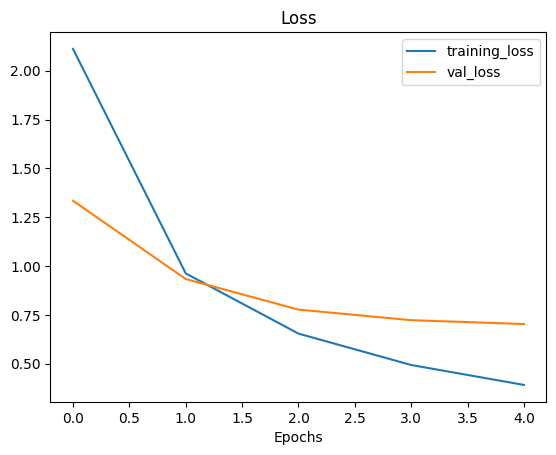

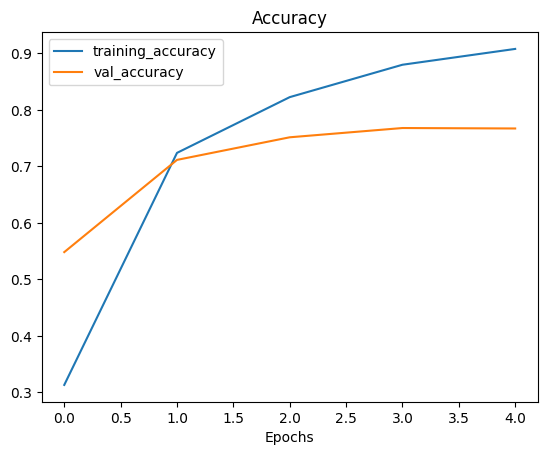

In [27]:
plot_loss_curves(resnet_history)

In [28]:
# Resnet summary
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [30]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes = train_data_10_percent.num_classes)

# Complie EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10 % of training data
                                             epochs=5,
                                             steps_per_epoch = len(train_data_10_percent),
                                             validation_data = test_data,
                                             validation_steps = len(test_data),
                                             callbacks = [create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                      #Track logs under different experiment name
                                                                                      experiment_name = 'efficientnetB0')])

Saving TensorBoard log file to : tensorflow_hub/efficientnetB0/20250531-130044
Epoch 1/5
24/24 [==============================] - 191s 8s/step - loss: 1.9513 - accuracy: 0.3547 - val_loss: 1.3588 - val_accuracy: 0.6940
Epoch 2/5
24/24 [==============================] - 174s 7s/step - loss: 1.1015 - accuracy: 0.7680 - val_loss: 0.8919 - val_accuracy: 0.8092
Epoch 3/5
24/24 [==============================] - 168s 7s/step - loss: 0.7646 - accuracy: 0.8453 - val_loss: 0.7096 - val_accuracy: 0.8452
Epoch 4/5
24/24 [==============================] - 170s 7s/step - loss: 0.6117 - accuracy: 0.8707 - val_loss: 0.6188 - val_accuracy: 0.8508
Epoch 5/5
24/24 [==============================] - 172s 7s/step - loss: 0.5178 - accuracy: 0.8907 - val_loss: 0.5620 - val_accuracy: 0.8580


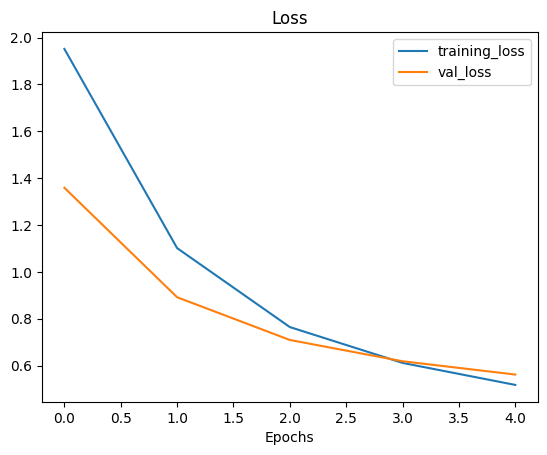

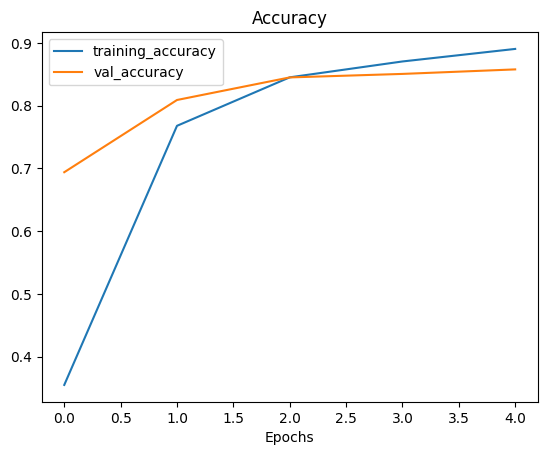

In [31]:
plot_loss_curves(efficientnet_history)

In [32]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


## Uploading experiments to TensorBoard

‼️‼️‼️‼️‼️‼️‼️‼️‼️
- --logdir is the target upload directory
- --name is the name of the experiment
- --description is a brief description of the experiment
- --one_shot exits the TensorBoard uploader once uploading is finished

In [33]:
# Upload TensorBoard dev recods
!tensorboard dev upload --logdir ./tensorflow_hub/\
    --name "EfficientNetB0 vs. ResNet50V2" \
    --description "Comparing two different TF Hub feature extraction models architectrues ustin 10% of training images" \
    --one_shot

/usr/local/lib/python3.11/dist-packages/tensorboard/default.py:30: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-05-31 13:24:45.675203: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-31 13:24:45.675254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-31 13:24:45.677016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-31 13:24:46.760713: W ten

In [ ]:
##  위에 보면 더 이상 tensorboard의 기능을 지원하지 않아 아래 코드는 사용하지 않았다.

## Listing esperiments you've saved to TensorBoard

In [ ]:
# Check out experiments
# !tensorboard dev list # uncomment to see

## Deleting experiments form TensorBoard

In [ ]:
# Delete an experiment
!tensorboard dev delete --experiment_id

In [ ]:
# Check to see if experiments still exist
# !tensorboard dev list # uncomment to see